In [10]:
import pandas as pd
import numpy as np
import gensim

from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))

from nltk.stem import WordNetLemmatizer
lemm=WordNetLemmatizer()

from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import models
from tensorflow.keras import layers

import string
import re

import warnings
warnings.simplefilter(action='ignore')

In [2]:
train=pd.read_csv('labeledTrainData.tsv',sep='\t')
train.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [3]:
test=pd.read_csv('testData.tsv',sep='\t')
test.head()

,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


In [25]:
def clean_text(review):
    #removing html content
    text=BeautifulSoup(review,'html.parser').get_text()
    
    #removing punctuation
    text=text.translate(str.maketrans('','',string.punctuation))
    
    #lowercase the words
    tokens=[token.lower() for token in text.split()]
    
    #removing stopwords
    tokens=[token for token in tokens  if token not in stop_words]
    
    #lemmatizing
    text=' '.join([lemm.lemmatize(token,'v') for token in tokens ])
    
    return text
    
    

In [26]:
train['cleaned_review']=train['review'].apply(lambda x:clean_text(x))

In [27]:
train.head()

,id,sentiment,review,cleaned_review
0,5814_8,1,With all this stuff going down at the moment w...,stuff go moment mj ive start listen music watc...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",classic war worlds timothy hines entertain fil...
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,film start manager nicholas bell give welcome ...
3,3630_4,0,It must be assumed that those who praised this...,must assume praise film greatest film opera ev...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,superbly trashy wondrously unpretentious 80s e...


In [28]:
test['cleaned_review']=test['review'].apply(lambda x:clean_text(x))
test.head()

,id,review,cleaned_review
0,12311_10,Naturally in a film who's main themes are of m...,naturally film whos main theme mortality nosta...
1,8348_2,This movie is a disaster within a disaster fil...,movie disaster within disaster film full great...
2,5828_4,"All in all, this is a movie for kids. We saw i...",movie kid saw tonight child love one point kid...
3,7186_2,Afraid of the Dark left me with the impression...,afraid dark leave impression several different...
4,12128_7,A very accurate depiction of small time mob li...,accurate depiction small time mob life film ne...


In [29]:
reviews=list(train['cleaned_review'])+list(test['cleaned_review'])
len(reviews)

50000

In [35]:
reviews_words=[]
for review in reviews:
    words=review.split()
    reviews_words.append(words)
    

In [36]:
model=gensim.models.Word2Vec(sentences=reviews_words,size=150,min_count=1,window=5,workers=4)


In [37]:
words=list(model.wv.vocab)
len(words)

209405

In [40]:
model.wv['stuff']

array([ 0.91882026,  0.57299626, -0.5107169 ,  0.04915435,  0.6959013 ,
       -0.16735728,  0.666746  , -0.01521455,  0.57011753,  0.36650798,
       -0.3219019 , -0.29890087,  0.15091684,  0.5221834 ,  1.0943922 ,
       -2.2064283 , -0.07473572,  0.901992  ,  0.57573813,  0.20457979,
        1.2271488 ,  1.0022261 ,  0.2219869 ,  0.80012727, -0.12569226,
       -0.13647012,  1.2266402 , -0.1361602 ,  1.8121647 , -0.65172213,
       -0.8436052 , -0.25737083, -0.14622143, -0.39335817,  0.44172835,
        0.93914217, -0.4443453 , -0.10878204, -0.19450134, -0.24392863,
       -0.5919301 , -0.05741752, -0.39574754,  0.0265872 , -0.06852854,
       -1.567893  , -1.8171711 , -0.6467526 ,  0.61336815, -0.84397185,
        0.17837408, -0.17309058, -0.310246  ,  0.15415232, -0.29085666,
       -0.724133  ,  0.7900474 , -1.062749  , -0.09767288, -1.2607449 ,
       -1.4162002 ,  1.1890931 ,  0.00660526,  0.47460994, -0.2796957 ,
        0.798757  , -0.39063466,  1.2193867 , -1.8880475 , -0.11

In [42]:
max_features=30000
tokenizer=Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train['cleaned_review'])
train_sequence=tokenizer.texts_to_sequences(train['cleaned_review'])
test_sequence=tokenizer.texts_to_sequences(test['cleaned_review'])

In [46]:
train['length']=train['cleaned_review'].apply(lambda x:len([token for token in x.split()]))
mean=train['length'].mean()
print(mean)

121.24776


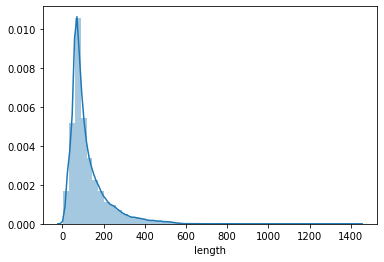

In [49]:
import seaborn as sns
sns.distplot(train['length']);

In [50]:
max_len=120
train_sequence=pad_sequences(train_sequence,maxlen=max_len,padding='post',truncating='post')
test_sequence=pad_sequences(test_sequence,maxlen=max_len,padding='post',truncating='post')

In [52]:
vocab_size=len(tokenizer.word_index)+1

In [54]:
embedding_matrix=np.zeros((vocab_size,150))
for word,i in tokenizer.word_index.items():
    embedding_vector=model.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector

In [56]:
labels=np.asarray(train['sentiment'])

In [59]:
model=models.Sequential([
    layers.Embedding(vocab_size,150,input_length=max_len,weights=[embedding_matrix]),
    layers.Bidirectional(layers.LSTM(64,dropout=0.2,recurrent_dropout=0.2)),
    layers.Dense(10,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1,activation='sigmoid')
])

In [60]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 150)          19697850  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               110080    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 19,809,231
Trainable params: 19,809,231
Non-trainable params: 0
_________________________________________________________________


In [61]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

In [62]:
hist=model.fit(train_sequence,labels,validation_split=0.2,epochs=5,verbose=1,batch_size=128)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 90s 5ms/sample - loss: 0.5159 - accuracy: 0.7549 - val_loss: 0.4522 - val_accuracy: 0.8048
Epoch 2/5
20000/20000 [==============================] - 79s 4ms/sample - loss: 0.4007 - accuracy: 0.8296 - val_loss: 0.3731 - val_accuracy: 0.8368
Epoch 3/5
20000/20000 [==============================] - 78s 4ms/sample - loss: 0.3466 - accuracy: 0.8568 - val_loss: 0.3572 - val_accuracy: 0.8566
Epoch 4/5
20000/20000 [==============================] - 77s 4ms/sample - loss: 0.3033 - accuracy: 0.8766 - val_loss: 0.3365 - val_accuracy: 0.8644
Epoch 5/5
20000/20000 [==============================] - 78s 4ms/sample - loss: 0.2687 - accuracy: 0.8957 - val_loss: 0.3036 - val_accuracy: 0.8752
